In [1]:
# Create GAN for MDP process of six sided die

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


class GAN:
    def __init__(self, seq_len=100):
        self.P = np.random.uniform(0, 1, (6, 6))
        # self.P = np.array([[0.5,0.5,0,0,0,0],[0,0.5,0.5,0,0,0],[0,0,0.5,0.5,0,0],[0,0,0,0.5,0.5,0],[0,0,0,0,0.5,0.5],[0.5,0,0,0,0,0.5]])
        # print(self.P, np.sum(self.P, axis=1, keepdims=True))
        self.P = self.P / np.sum(self.P, axis=1, keepdims=True)
        self.seq_len = seq_len
        # print(self.P)
        self.build_generator()
        self.build_discriminator()
        self.build_gan()
        print(self.P)
    
    def generate_real_samples(self, n_samples):
        X_total = []
        for i in range(n_samples):
            X = [np.random.choice(6)]
            for i in range(1, self.seq_len):
                X.append(np.random.choice(6, p=self.P[X[i - 1]]))
            X = np.array(X)
            X = tf.keras.utils.to_categorical(X, num_classes=6)
            X_total.append(X)
        X = np.array(X_total)
        y = np.ones((n_samples, 1)) * 0.9
        # print(X.shape, y.shape)
        return X, y
    
    def generate_fake_samples(self, n_samples):
        X = self.generator.predict(np.random.normal(0, 1, (n_samples, 25)))
        y = np.zeros((n_samples, 1))
        return X, y
    
    def calculate_P(self, n_samples):
        X, _ = self.generate_fake_samples(n_samples)
        X = np.argmax(X, axis=2)
        P = np.zeros((6, 6))
        for i in range(n_samples):
            for j in range(self.seq_len - 1):
                P[X[i, j], X[i, j + 1]] += 1
                
        P = P / np.sum(P, axis=1, keepdims=True)
        return P
    
    def calculate_P_real(self, n_samples):
        X, _ = self.generate_real_samples(n_samples)
        X = np.argmax(X, axis=2)
        P = np.zeros((6, 6))
        for i in range(n_samples):
            for j in range(self.seq_len - 1):
                P[X[i, j], X[i, j + 1]] += 1
                
        P = P / np.sum(P, axis=1, keepdims=True)
        return P
    def build_generator(self):
        self.generator = tf.keras.models.Sequential([
            tf.keras.layers.Dense(25 * 200, input_shape=(25,)),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Reshape((25, 200)), 
            tf.keras.layers.Conv1DTranspose(100, 3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv1DTranspose(50, 3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv1DTranspose(6, 3, strides=1, padding='same', activation='softmax'),
        ])
    def summarize_generator(self):
        self.generator.summary()
        # tf.keras.utils.plot_model(self.generator, show_shapes=True, dpi=64)

    def build_discriminator(self):
        self.discriminator = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(50, 3, strides=2, padding='same', input_shape=(self.seq_len, 6)),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv1D(100, 3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv1D(200, 3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])
        self.discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    def summarize_discriminator(self):
        self.discriminator.summary()
        # tf.keras.utils.plot_model(self.discriminator, show_shapes=True, dpi=64)
    
    def build_gan(self):
        self.discriminator.trainable = False
        self.gan = tf.keras.models.Sequential([
            self.generator,
            self.discriminator,
        ])
        self.gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())
        
    def train(self, epochs = 1000, batch_size = 128):
        l1_hist = []
        l2_hist = []
        l3_hist = []
        ac1_hist = []
        ac2_hist = []
        total = 100000//batch_size
        train_data_x, train_data_y = self.generate_real_samples(10000)
        for i in range(epochs):
            print("Iteration:", i)
            # Train the discriminator
            
            for k in range(total):
                print(k,"/",total,end="\r")
                idx = np.random.randint(0, 10000, batch_size//2)
                X_real, y_real = train_data_x[idx], train_data_y[idx]
                # X_real, y_real = self.generate_real_samples(batch_size//2)
                X_fake, y_fake = self.generate_fake_samples(batch_size//2)
                

                # Train the discriminator
                l1, ac1 = self.discriminator.train_on_batch(X_real, y_real)
                
                l2, ac2 = self.discriminator.train_on_batch(X_fake, y_fake)

                X_fake = np.random.normal(0, 1, (batch_size, 25))
                y_fake = np.ones((batch_size, 1))
                l3 = self.gan.train_on_batch(X_fake, y_fake)
                
                l1_hist.append(l1)
                l2_hist.append(l2)
                l3_hist.append(l3)
                ac1_hist.append(ac1)
                ac2_hist.append(ac2)
                
            # Show plots of the losses and accuracies
            calc_p = self.calculate_P(100000)
            print(calc_p)
            print("Loss:",np.mean(np.abs(calc_p - self.P)))
            if i % 10 >= 0:
                plt.figure(figsize=(10, 10))
                plt.subplot(2, 1, 1)
                plt.plot(l1_hist, label="Discriminator(Real)")
                plt.plot(l2_hist, label="Discriminator(Fake)")
                plt.plot(l3_hist, label="Generator")
                plt.legend()
                plt.title("Losses")
                plt.subplot(2, 1, 2)
                plt.plot(ac1_hist, label="Accuracy(Real)")
                plt.plot(ac2_hist, label="Accuracy(fake)")
                plt.legend()
                plt.title("Accuracies")
                plt.show()
                l1_hist = []
                l2_hist = []
                l3_hist = []
                ac1_hist = []
                ac2_hist = []

2024-02-01 05:28:22.785361: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 05:28:22.785416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 05:28:22.787126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 05:28:22.796482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 05:28:24.546677: W tensorflow/compiler/tf2

In [2]:
gan = GAN()

2024-02-01 05:28:29.355556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


[[0.23867786 0.13615362 0.11758157 0.24404546 0.04085465 0.22268684]
 [0.24349034 0.07329679 0.15690985 0.07583933 0.18698522 0.26347846]
 [0.240436   0.08132391 0.22944185 0.20637797 0.18897682 0.05344344]
 [0.21901619 0.16784117 0.1072158  0.19183209 0.11689579 0.19719895]
 [0.22500125 0.01056256 0.02818102 0.1276922  0.3483114  0.26025158]
 [0.17185615 0.2243389  0.13008823 0.04504822 0.2314952  0.19717331]]


In [3]:
gan.summarize_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5000)              130000    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5000)              0         
                                                                 
 reshape (Reshape)           (None, 25, 200)           0         
                                                                 
 conv1d_transpose (Conv1DTr  (None, 50, 100)           60100     
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 50, 100)           0         
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 100, 50)           15050     
 Transpose)                                             

In [4]:
tf.keras.utils.plot_model(gan.generator, show_shapes=True, dpi=64)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [5]:
tf.keras.utils.plot_model(gan.discriminator, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
tf.keras.utils.plot_model(gan.gan, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [7]:
gan.summarize_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 50)            950       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 50, 50)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 100)           15100     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 25, 100)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 200)           60200     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 13, 200)           0         
                                                                 
 flatten (Flatten)           (None, 2600)             

In [8]:
gan.gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 6)            206056    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 78851     
                                                                 
Total params: 284907 (1.09 MB)
Trainable params: 206056 (804.91 KB)
Non-trainable params: 78851 (308.01 KB)
_________________________________________________________________


Iteration: 0


2024-02-01 05:28:51.053743: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-01 05:28:52.217360: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-01 05:28:53.140727: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-01 05:28:53.616662: I external/local_xla/xla/service/service.cc:168] XLA service 0x1526102cc6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-01 05:28:53.616703: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-02-01 05:28:53.623501: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706745533.774769   16425 device_compil

/tmp/ipykernel_16359/3847676067.py:48: RuntimeWarning: invalid value encountered in divide
  P = P / np.sum(P, axis=1, keepdims=True)


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [           nan            nan            nan            nan
             nan            nan]
 [3.29187762e-06 0.00000000e+00 3.29187762e-05 9.99963789e-01
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.39529649e-02 9.66041616e-01
  0.00000000e+00 5.41900192e-06]
 [           nan            nan            nan            nan
             nan            nan]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Loss: nan


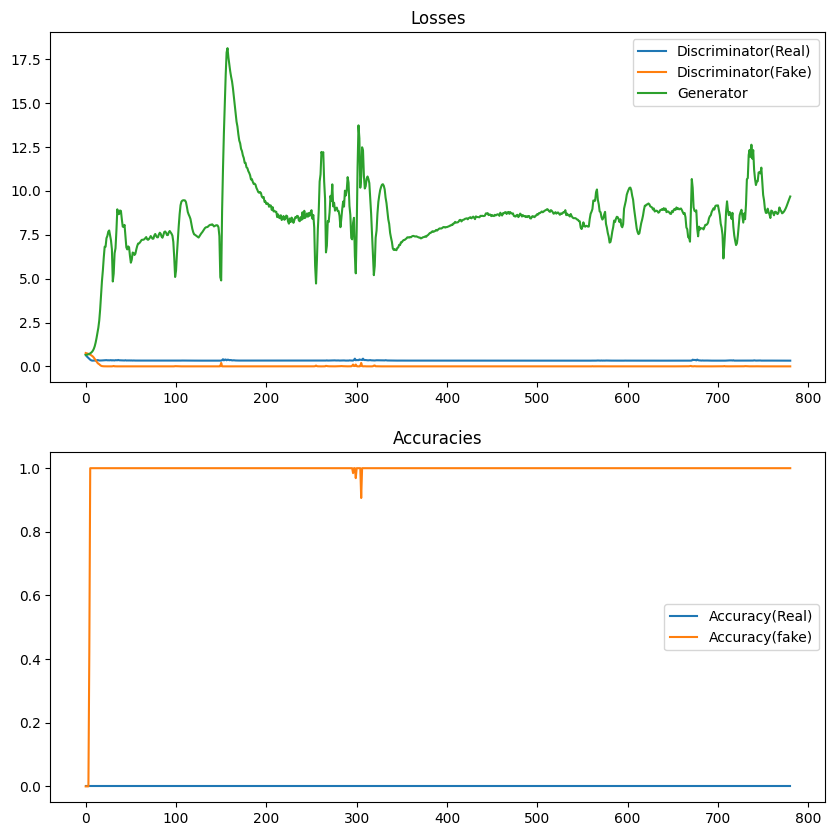

Iteration: 1
[[1.86103551e-01 4.05511968e-02 3.78415050e-02 7.98141926e-07
  0.00000000e+00 7.35502949e-01]
 [8.10394340e-01 6.38188102e-02 5.28929884e-02 9.41763527e-05
  0.00000000e+00 7.27996855e-02]
 [7.10451694e-02 1.62351949e-01 7.66269373e-01 2.80147619e-05
  0.00000000e+00 3.05494308e-04]
 [2.80463714e-02 2.10178831e-02 6.32142857e-01 1.77032647e-01
  5.19858598e-06 1.41755043e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [3.58512012e-02 3.53116994e-03 1.60830913e-01 4.18634754e-02
  0.00000000e+00 7.57923240e-01]]
Loss: 0.1974302090839908


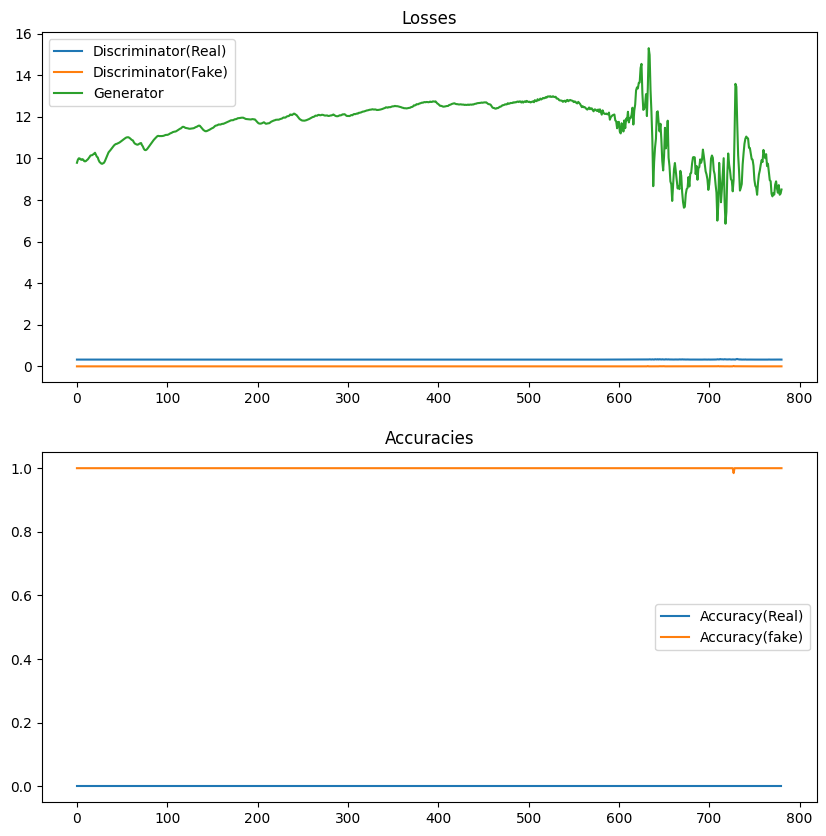

Iteration: 2
[[2.24550997e-01 3.91773701e-01 1.73616869e-02 3.17018049e-01
  6.55096040e-03 4.27446061e-02]
 [4.66274211e-02 2.17089157e-01 1.32076765e-01 5.28666587e-02
  2.41480117e-02 5.27191987e-01]
 [2.94389509e-01 6.17118456e-02 2.41266618e-01 3.48834209e-01
  5.20198253e-02 1.77799216e-03]
 [1.92705894e-01 4.97069546e-02 1.67192465e-04 2.58859790e-01
  1.21509416e-01 3.77050753e-01]
 [5.15065786e-02 1.42518497e-02 1.45024740e-02 8.74633847e-02
  6.84689388e-01 1.47586325e-01]
 [1.27579108e-01 1.30530682e-01 9.76249933e-02 4.34255705e-02
  5.39265706e-01 6.15739409e-02]]
Loss: 0.1024257765476947


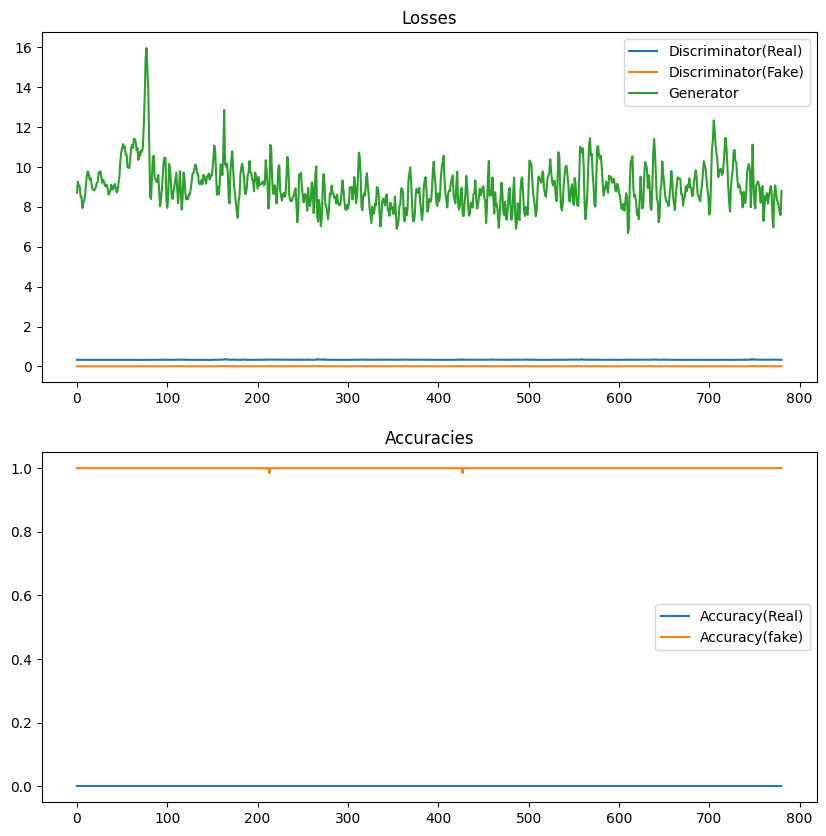

Iteration: 3
[[0.3423275  0.18687645 0.05041853 0.22531829 0.05127196 0.14378726]
 [0.61259738 0.03292087 0.04051277 0.00135003 0.11280608 0.19981287]
 [0.18169056 0.11013343 0.14437506 0.36054844 0.12871467 0.07453784]
 [0.31691056 0.13413486 0.06407208 0.26507037 0.1311592  0.08865294]
 [0.03632893 0.00652313 0.00921473 0.30203581 0.35240128 0.29349612]
 [0.21259133 0.05780651 0.09950866 0.04027832 0.28830682 0.30150837]]
Loss: 0.07427373088686234


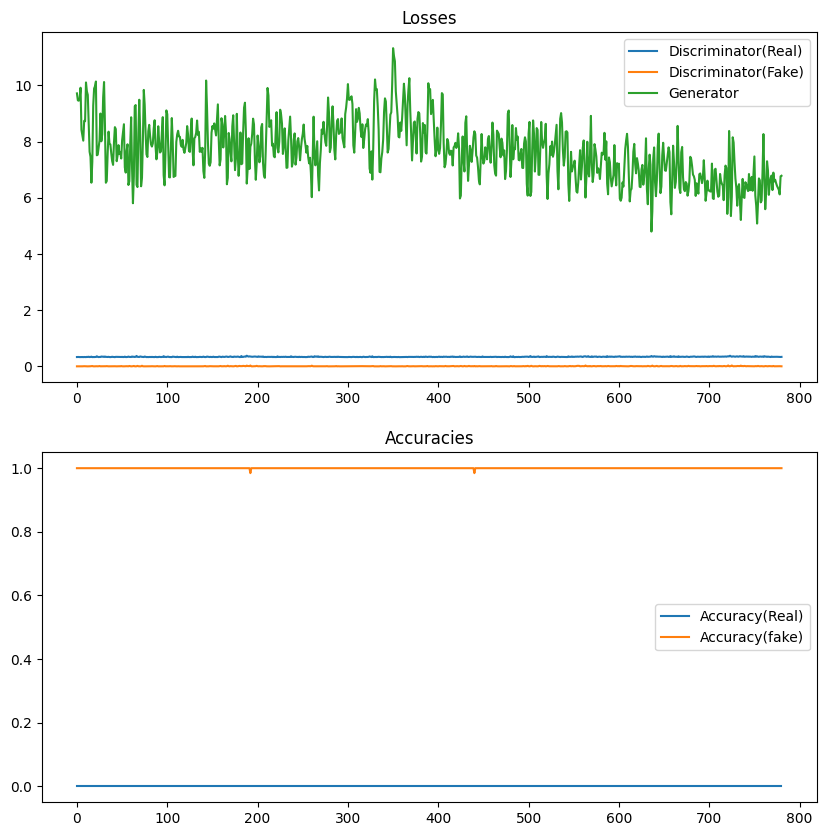

Iteration: 4
[[0.34182057 0.13608693 0.19989118 0.09380383 0.02127175 0.20712574]
 [0.25209081 0.15511532 0.01418942 0.04655492 0.3392479  0.19280163]
 [0.40147233 0.12009339 0.0764639  0.30677162 0.0578796  0.03731915]
 [0.23481466 0.05274137 0.17008161 0.28202106 0.03932844 0.22101286]
 [0.09242639 0.03603898 0.03942125 0.06116944 0.45485928 0.31608467]
 [0.11943862 0.16226248 0.19443589 0.09638698 0.30046989 0.12700614]]
Loss: 0.07248663055864196


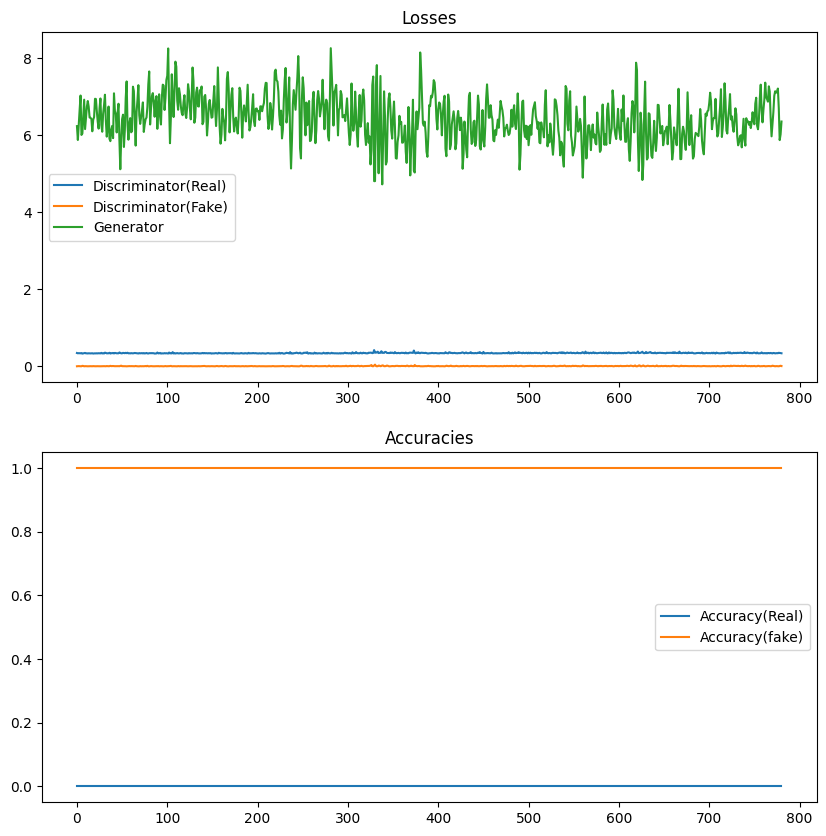

Iteration: 5


In [ ]:
tf.keras.utils.disable_interactive_logging()
gan.train(10)

In [ ]:
calc_p = gan.calculate_P(100000)
print(calc_p)

In [ ]:
test_p = np.random.uniform(0, 1, (6, 6))
test_p = test_p / np.sum(test_p, axis=1, keepdims=True)
print(test_p)
print(np.mean(np.abs(gan.P - test_p)))